In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("../utility")
from inference import recover_controls_for_trajectory, load_koopman_model, predict_next_states
from dataset import KoopmanDatasetCollector
import torch
import pandas as pd

In [62]:
dataset = torch.load('../data/datasets/dataset_G1CartPole_norm_train_60000_val_20000_test_20000_steps_50.pt', weights_only=False)
test_data = dataset["test_data"]
train_state_mean = dataset["train_state_mean"]
train_state_std = dataset["train_state_std"]
train_control_mean = dataset["train_control_mean"]
train_control_std = dataset["train_control_std"]

u_dim = 7
state_dim = 16

In [63]:
test_data.shape

(51, 20000, 23)

In [64]:
torque_data = test_data[:,:1, :u_dim].reshape(-1, u_dim)
state_data = test_data[:,:1, u_dim:].reshape(-1, state_dim)

In [65]:
torque_data.shape

(51, 7)

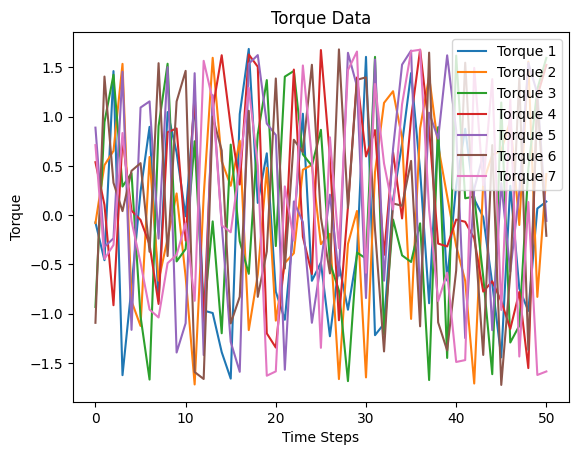

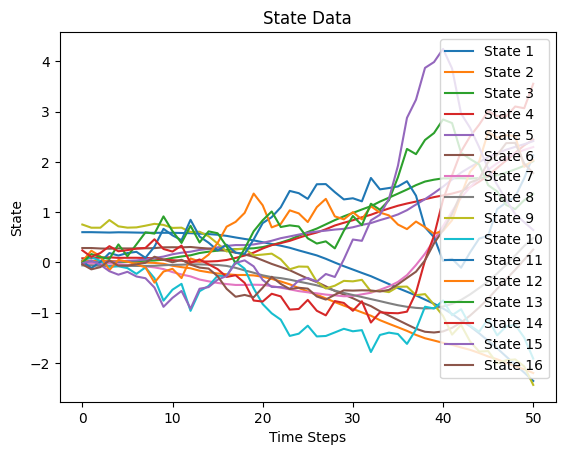

In [66]:
for i in range(u_dim):
    plt.plot(torque_data[:, i], label=f'Torque {i+1}')
plt.title('Torque Data')
plt.xlabel('Time Steps')
plt.ylabel('Torque')
plt.legend()
plt.show()
for i in range(state_dim):
    plt.plot(state_data[:, i], label=f'State {i+1}')
plt.title('State Data')
plt.xlabel('Time Steps')
plt.ylabel('State')
plt.legend()
plt.show()

In [67]:
# recover state and control data using mean and std
recovered_torque_data = (torque_data * train_control_std) + train_control_mean
recovered_state_data = (state_data * train_state_std) + train_state_mean

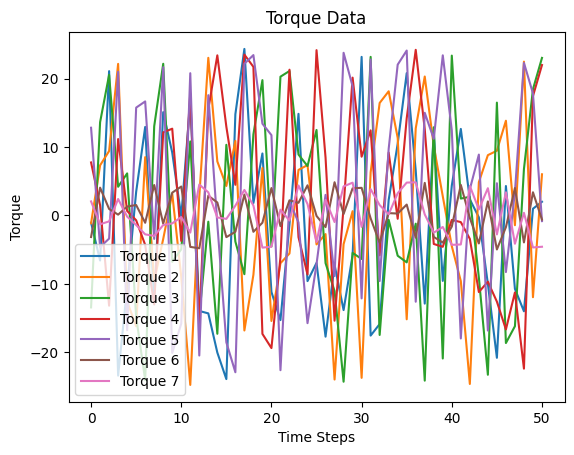

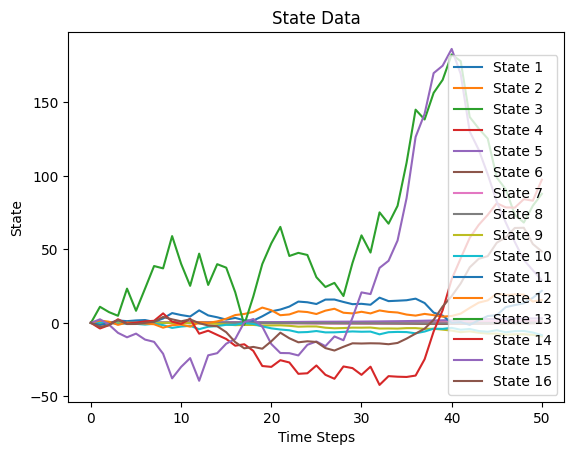

In [68]:
for i in range(u_dim):
    plt.plot(recovered_torque_data[:, i], label=f'Torque {i+1}')
plt.title('Torque Data')
plt.xlabel('Time Steps')
plt.ylabel('Torque')
plt.legend()
plt.show()
for i in range(state_dim):
    plt.plot(recovered_state_data[:, i], label=f'State {i+1}')
plt.title('State Data')
plt.xlabel('Time Steps')
plt.ylabel('State')
plt.legend()
plt.show()

In [9]:
bad_idx = 12484
# cleaned_data = np.delete(raw_data, bad_idx, axis=1)  # axis=1 is trajectory dimension
# np.save('../data/datasets/g1_cartpole_data/G1_cartpole_data_cleaned.npy', cleaned_data)

Checkpoint keys: dict_keys(['model', 'layer'])
env_name: G1CartPole


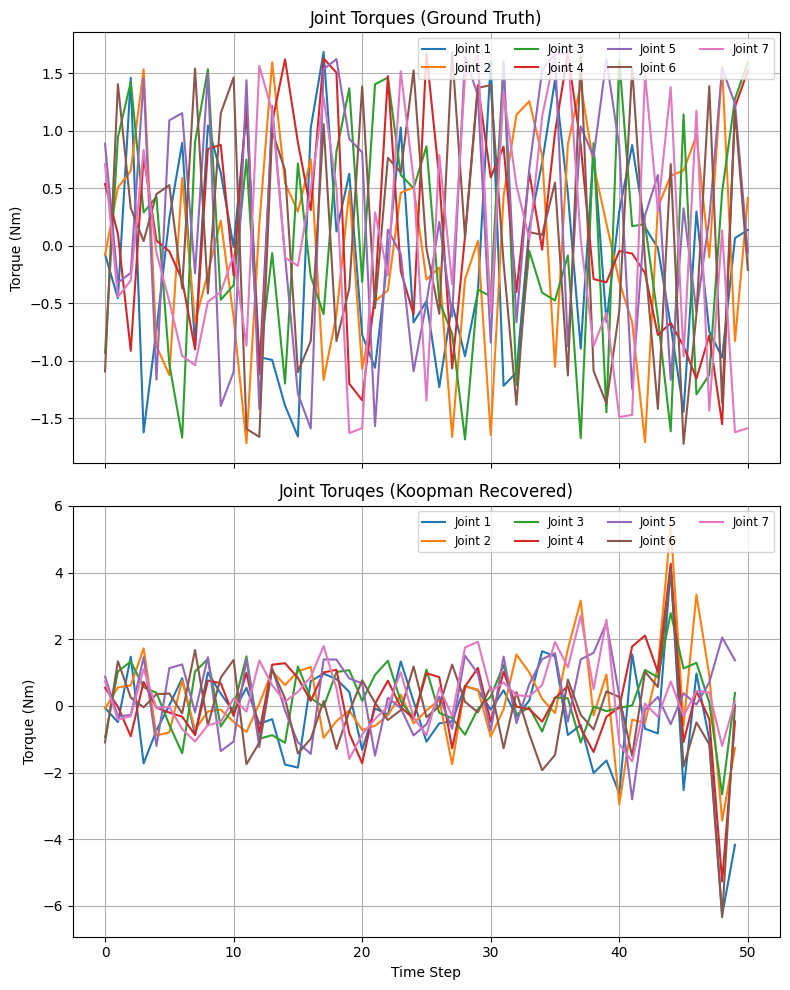

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = load_koopman_model("../log/best_models/G1/best_model_norm_G1CartPole_512_1_1_1.pth",device)

koopman_torque_data = recover_controls_for_trajectory(state_data,net,device=device).detach().cpu().numpy()
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# Plot torques
for i in range(7):
    axs[0].plot(torque_data[:, i], label=f'Joint {i+1}')
axs[0].set_title('Joint Torques (Ground Truth)')
axs[0].set_ylabel('Torque (Nm)')
axs[0].legend(loc='upper right', ncol=4, fontsize='small')
axs[0].grid(True)

# Plot velocities
for i in range(7):
    axs[1].plot(koopman_torque_data[:, i], label=f'Joint {i+1}')
axs[1].set_title('Joint Toruqes (Koopman Recovered)')
axs[1].set_xlabel('Time Step')
axs[1].set_ylabel('Torque (Nm)')
axs[1].legend(loc='upper right', ncol=4, fontsize='small')
axs[1].grid(True)
plt.tight_layout()
plt.show()

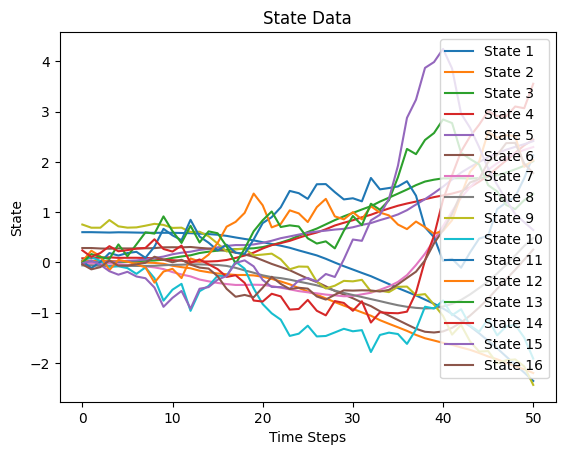

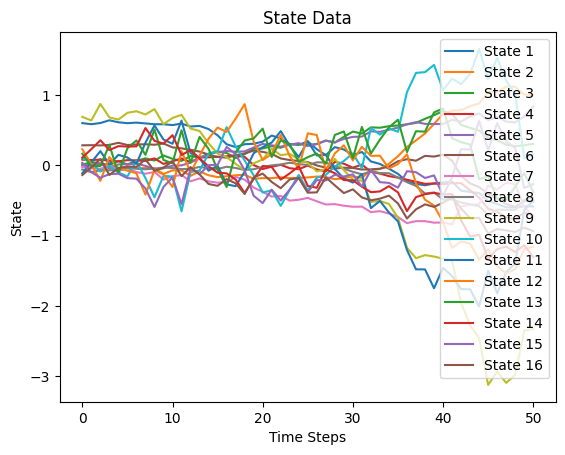

In [70]:
koopman_predicted_state_data = predict_next_states(state_data, torque_data, net, device=device).detach().cpu().numpy()
for i in range(state_dim):
    plt.plot(state_data[:, i], label=f'State {i+1}')
plt.title('State Data')
plt.xlabel('Time Steps')
plt.ylabel('State')
plt.legend()
plt.show()
for i in range(state_dim):
    plt.plot(koopman_predicted_state_data[:, i], label=f'State {i+1}')
plt.title('State Data')
plt.xlabel('Time Steps')
plt.ylabel('State')
plt.legend()
plt.show()